In [161]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [162]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [163]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten   #reduces overfitting =dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle #to unpickle the serialised character string data in the pickle files:test.p, train.p, valid.p
import pandas as pd
import random 
import cv2

In [164]:
np.random.seed(0)

In [165]:
#unpickling the data files
with open('german-traffic-signs/train.p', 'rb') as f:
      train_data = pickle.load(f)               
with open('german-traffic-signs/valid.p', 'rb') as f:
      valid_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
      test_data = pickle.load(f)
print(type(train_data))   

X_train, y_train = train_data['features'], train_data['labels']
X_valid, y_valid = valid_data['features'], valid_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

#printing shapes of the datasets
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

<class 'dict'>
(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [166]:
#asserting to check if the data is correctly imported

assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_valid.shape[0] == y_valid.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32X32X3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32X32X3"
assert(X_valid.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32X32X3"



In [167]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

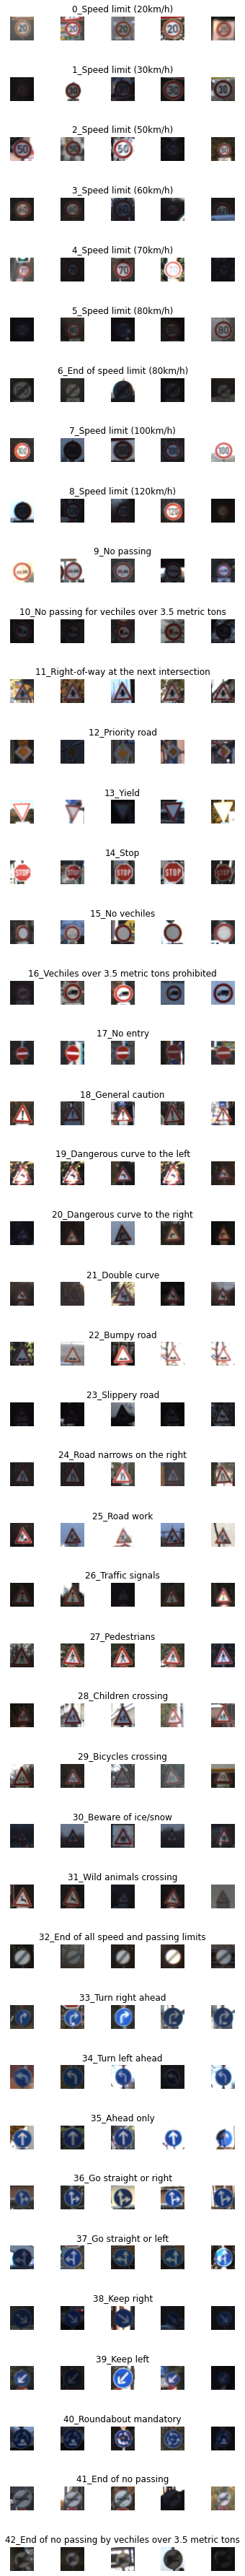

In [168]:
num_of_samples = []
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "_" + row["SignName"])
            num_of_samples.append(len(x_selected))
    
    #(index, Series)           

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

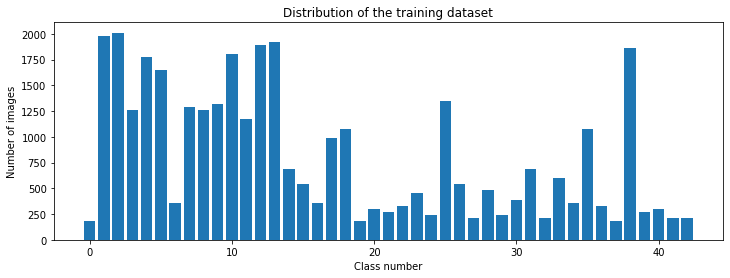

In [169]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
#observation: non-uniform distribution of images

(32, 32, 3)
23


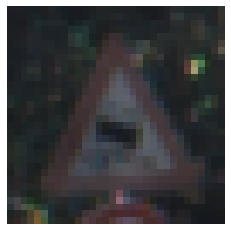

In [170]:
import cv2
plt.imshow(X_train[2000])
plt.axis("off")
print(X_train[2000].shape)
print(y_train[2000])

In [171]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img



In [172]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img



In [173]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  #use normalisation
  img = img/255
  return img

#passing dataset through this function
X_train = np.array(list(map(preprocessing, X_train)))
X_test = np.array(list(map(preprocessing, X_test)))
X_valid = np.array(list(map(preprocessing, X_valid)))

(34799, 32, 32)


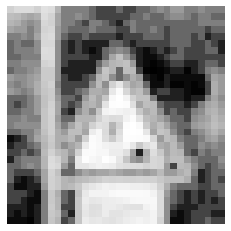

In [174]:
#plotting the entire dataset for visulaisation
plt.imshow(X_train[random.randint(0, len(X_train)-1)], cmap=plt.get_cmap("gray"))
plt.axis("off")
print(X_train.shape)

In [175]:
#reshaping the dataset to include the depth that is 1 dimension
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_valid = X_valid.reshape(4410, 32, 32, 1)


In [176]:

#data augmentation to increase number of image instances with added rotation and shifts/zooming
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2,shear_range=0.1, rotation_range=10 )
datagen.fit(X_train)

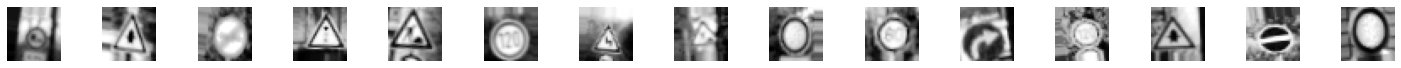

In [177]:
batches = datagen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize = (20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32), cmap=plt.get_cmap("gray"))
    axs[i].axis('off')

In [178]:
#new dimensions
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

#one hot encoding to the y_labels to remove dependency
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_valid = to_categorical(y_valid, 43)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [179]:
#leNet implementation 

def leNetmodified_model():
    model = Sequential()
    model.add(Conv2D(60, (5,5), input_shape=(32, 32, 1), activation='relu')) #adding first convolutional layer, improv #2 increasing no.of filters
    model.add(Conv2D(60, (5,5), activation='relu')) #improv #3: adding convolution layer
    model.add(MaxPooling2D(pool_size=(2,2)))#adding pooling layer for avoiding overfitting and scales down image, doesn't affects the depth
    
    model.add(Conv2D(30, (3,3), activation='relu'))  #another convolutional layer, depth=30
    model.add(Conv2D(30, (3,3), activation='relu')) #improv #3: adding convolution layer
    model.add(MaxPooling2D(pool_size=(2,2)))#another pooling layer
    #model.add(Dropout(0.5))#adding dropout layer improv #4
        
    model.add(Flatten())#flatten to format the data to fed into the fully connected layer
    model.add(Dense(500, activation='relu')) #adding dense/fully connected layer
    model.add(Dropout(0.5))#adding dropout layer, half the nodes are dropped for each update
    model.add(Dense(num_classes, activation='softmax'))#adding output layer

    #compile model
    model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy']) #from lr=0.01 to lr= 0.001 update
    return model


In [180]:
model = leNetmodified_model()
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 480)              

In [181]:
#training model
#hist = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), batch_size=400, verbose=1, shuffle=1)

#fitting including the datagen improv #5
hist = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50), 
                           steps_per_epoch=695, epochs=15, validation_data=(X_valid, y_valid), shuffle=1)

Epoch 1/15
695/695 [==============================] - 13s 18ms/step - loss: 1.6439 - accuracy: 0.5289 - val_loss: 0.3081 - val_accuracy: 0.9054
Epoch 2/15
695/695 [==============================] - 13s 19ms/step - loss: 0.5087 - accuracy: 0.8403 - val_loss: 0.1023 - val_accuracy: 0.9719
Epoch 3/15
695/695 [==============================] - 12s 18ms/step - loss: 0.3141 - accuracy: 0.9019 - val_loss: 0.0667 - val_accuracy: 0.9805
Epoch 4/15
695/695 [==============================] - 12s 18ms/step - loss: 0.2338 - accuracy: 0.9283 - val_loss: 0.0565 - val_accuracy: 0.9853
Epoch 5/15
695/695 [==============================] - 12s 18ms/step - loss: 0.1991 - accuracy: 0.9392 - val_loss: 0.0523 - val_accuracy: 0.9834
Epoch 6/15
695/695 [==============================] - 12s 18ms/step - loss: 0.1615 - accuracy: 0.9503 - val_loss: 0.0426 - val_accuracy: 0.9882
Epoch 7/15
695/695 [==============================] - 12s 17ms/step - loss: 0.1451 - accuracy: 0.9550 - val_loss: 0.0693 - val_accuracy:

Text(0.5, 0, 'epoch')

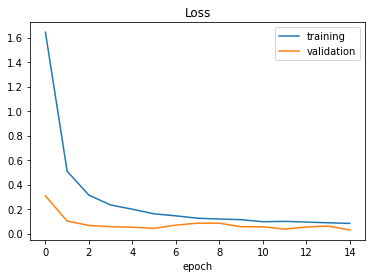

In [182]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

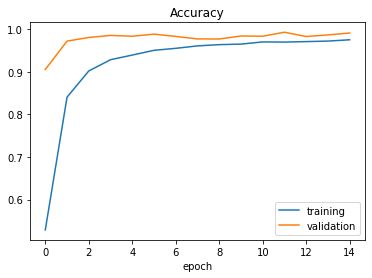

In [183]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [184]:
#checking the score for the model will give the performance at a glance
score = model.evaluate(X_test, y_test, verbose=1)

print('Test Score:', score[0])
print('Accuracy:', score[1])

395/395 [==============================] - 1s 3ms/step - loss: 0.1039 - accuracy: 0.9696
Test Score: 0.10392078012228012
Accuracy: 0.9695962071418762


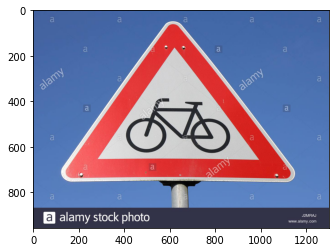

In [185]:
#fetching image for testing the code
 
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)
predicted sign: [29]
<class 'numpy.ndarray'>


Text(0, 0.5, 'Probability amongst Dataset')

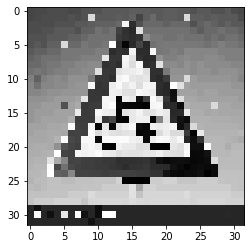

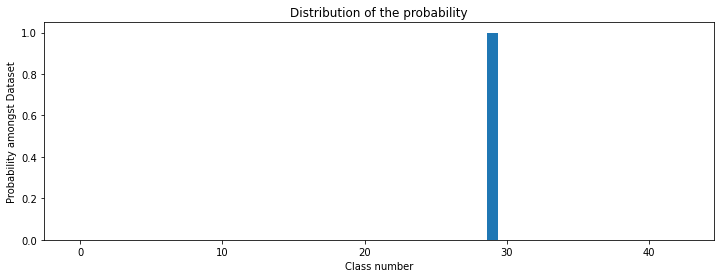

In [186]:
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
 
#Reshape for feeding to the neural network
 
img = img.reshape(1, 32, 32, 1)
 
#Test image
print("predicted sign: "+ str(model.predict_classes(img)))
#plotting probability
probab = ((model.predict_proba(img)))
probab = probab.flatten()
print(type(probab))
#"""
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), probab)
plt.title("Distribution of the probability")
plt.xlabel("Class number")
plt.ylabel("Probability amongst Dataset")
#"""